![alt text](../img/general/header.png)

## High-Level Synthesis for Machine Learning (hls4ml)


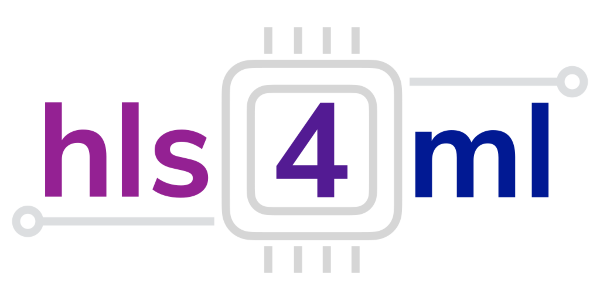

💡 **High-Level Synthesis for Machine Learning (hls4ml)** es una biblioteca de código abierto diseñada para convertir modelos de aprendizaje automático en descripciones de hardware optimizadas para su implementación en FPGAs 

**Características de hls4ml:** 

- Convierte modelos de Keras, TensorFlow, PyTorch, y ONNX en proyectos HLS (High-Level Synthesis).

- Usa herramientas como Xilinx Vitis HLS y Intel HLS Compiler para generar código en C++ optimizado para hardware.

- Permite reducir la latencia y el consumo de energía, mejorando la eficiencia en implementaciones de IA en edge computing.

- Soporta técnicas de cuantización y pruning para reducir el tamaño del modelo sin afectar significativamente su precisión.

**Aplicaciones de hls4ml:**

- Procesamiento en tiempo real en sistemas embebidos.

- Implementación de redes neuronales en hardware de baja potencia.

- Aceleración de modelos de IA en aplicaciones como física de partículas, visión artificial y robótica.


Para más información:

- GitHub: https://github.com/fastmachinelearning/hls4ml

- Web site: https://fastmachinelearning.org/hls4ml/

---

### Librerías

In [2]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
import hls4ml
import matplotlib.pyplot as plt


2025-03-21 22:10:25.860549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


### Path a Vitis HLS


Como paso inicial se debe especificar el directorio de instalación de Vivado HLS o Vitis HLS. 

In [3]:
os.environ['PATH'] = '/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:' + os.environ['PATH']
os.environ['PATH']


'/tools/Xilinx/XilinxUnified_2022/Vitis_HLS/2022.2/bin:/tools/anaconda3/envs/neuralEnv/bin:/tools/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin'

### Carga del modelo (.h5)

Carga del modelo pre-entrenado y guardado en formato **.h5**. 

Para este laboratorio, el modelo fue generado en el **lab03**.

In [4]:

from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)
# model = load_model('../lab03/models/mnistKD_P.h5', custom_objects=co)
model = load_model('../lab03/models/mnistQPKD.h5', custom_objects=co)
    
# Resumen del modelo
model.summary()


2025-03-21 22:10:29.778438: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-03-21 22:10:29.779090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-03-21 22:10:30.251314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-21 22:10:30.251509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 with Max-Q Design computeCapability: 7.5
coreClock: 1.155GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 149.04GiB/s
2025-03-21 22:10:30.251541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-03-21 22:10:30.294186: I tensorflow/stream_ex

Model: "quantizedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1_input (QDense)           (None, 5)                 3925      
_________________________________________________________________
relu_input (QActivation)     (None, 5)                 0         
_________________________________________________________________
fc1 (QDense)                 (None, 7)                 42        
_________________________________________________________________
relu1 (QActivation)          (None, 7)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7)                 0         
_________________________________________________________________
output (QDense)              (None, 10)                80        
_________________________________________________________________
softmax (Activation)         (None, 10)             

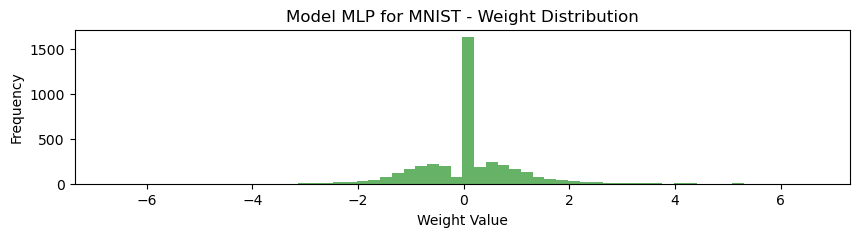

In [5]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=60, color='green', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Model MLP for MNIST - Weight Distribution")
plt.show()


In [ ]:
# Observar el valor de los pesos (weights)
weights

In [ ]:
array_color = ['green', 'red', 'purple', 'yellow']

for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if len(weights) > 0:  # Ensure the layer has weights
        plt.figure(figsize=(10,2))
        plt.hist(weights[0].flatten(), bins=60, color=array_color[i], alpha=0.6)
        plt.title(f"Layer {i} - Model MLP for MNIST - Weight Distribution")
        plt.show()

### hls4ml 

💡 Arbitrary precision reference: https://docs.amd.com/r/2022.2-English/ug1399-vitis-hls/Fixed-Point-Identifier-Summary?tocId=jgeN4rPFF_M6nxbDn1H5HA

In [6]:
# hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'])
# hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(rounding_mode='AP_RND')
# hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(saturation_mode='AP_SAT')


hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

import plotting

print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")




Interpreting Sequential
Topology:
Layer name: fc1_input_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1_input, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 5]
Layer name: relu_input, layer type: Activation, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: fc1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 7]
Layer name: relu1, layer type: Activation, input shapes: [[None, 7]], output shape: [None, 7]
Layer name: output, layer type: QDense, input shapes: [[None, 7]], output shape: [None, 10]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  fc1_input_input
    Trace:           False
    Precision
      result:        fixed<16,6>
  fc1_

In [17]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28 * 28)                       # Aplanar imágenes
x_test = x_test.reshape(-1, 28 * 28)
x_test = x_test.astype(float)

# y_train = to_categorical(y_train, num_classes=10, dtype=int)
# y_test = to_categorical(y_test, num_classes=10, dtype=int)

Interpreting Sequential
Topology:
Layer name: fc1_input_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1_input, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 5]
Layer name: relu_input, layer type: Activation, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: fc1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 7]
Layer name: relu1, layer type: Activation, input shapes: [[None, 7]], output shape: [None, 7]
Layer name: output, layer type: QDense, input shapes: [[None, 7]], output shape: [None, 10]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1_input, layer type: QDense, input shapes: [[None, 784]], output shape: [None, 5]
Layer name: relu_input, layer type: A

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/hls4ml/backends/fpga/passes/fix_softmax_table_size.py:34: UserWarning: Softmax layer softmax table size is too large for inputbitwidth 8. Setting table size to 256.To avoid this warning, please increase input bitwidth ordecrease table size.
  warnings.warn(


Profiling weights (final / after optimization)
Profiling activations (before optimization)
   fc1_input
   relu_input
   fc1
   relu1
   dropout_1
   output
   softmax
Profiling activations (final / after optimization)
Recompiling myproject with tracing
Writing HLS project
Done
   fc1_input
   fc1_input_linear
   relu_input
   fc1
   output
   softmax


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

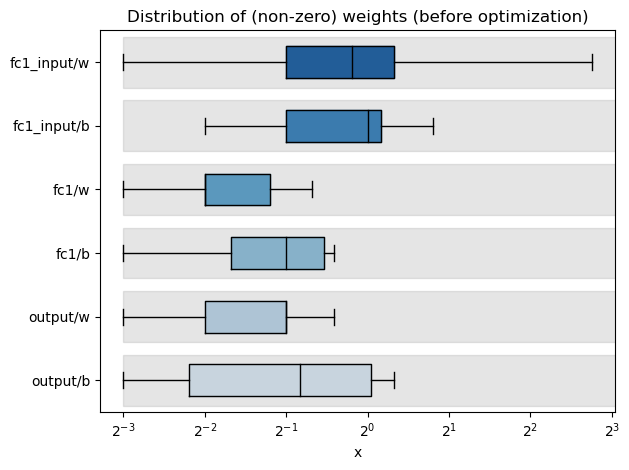

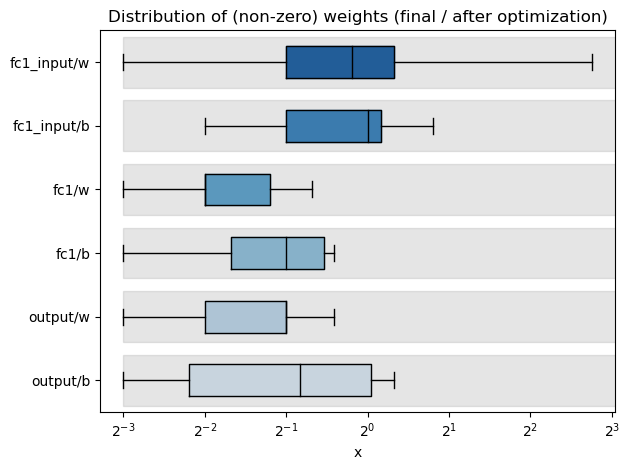

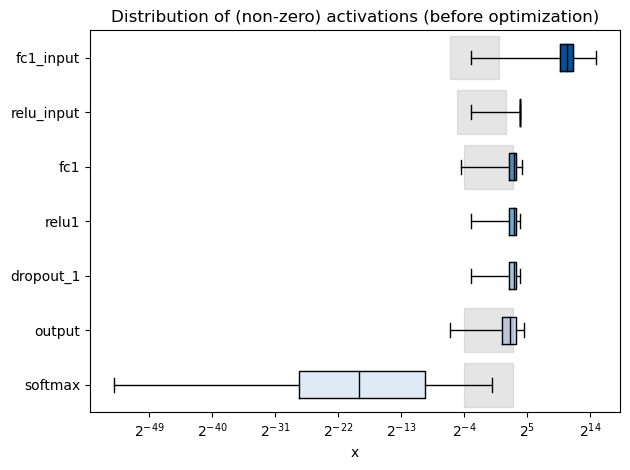

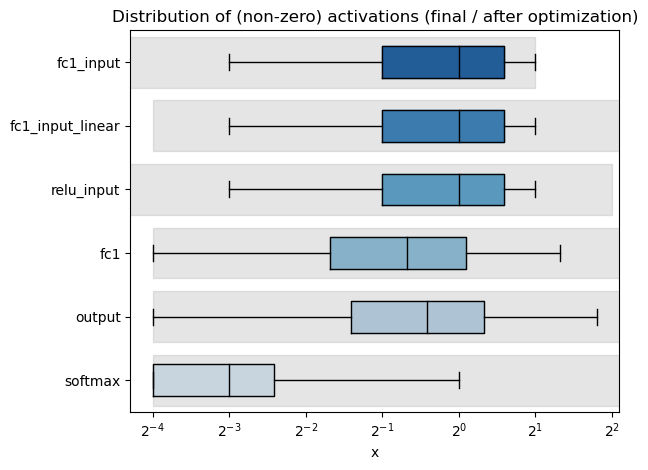

In [23]:
from hls4ml.model.profiling import numerical, get_ymodel_keras


# for Layer in hls_config['LayerName'].keys():
#     hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
#     hls_config['LayerName'][Layer]['ReuseFactor'] = 16
#     hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<8,4>'

hls_config['LayerName']['fc1_input_input']['Precision'] = 'ap_fixed<16, 6>'  

hls_config['LayerName']['fc1_input']['Precision'] = 'ap_fixed<8, 2>'   # the name input_2 could be different!  

hls_config['LayerName']['relu_input']['Precision'] = 'ap_fixed<8, 3>'
# hls_config['LayerName']['softmax']['Precision'] = 'ap_fixed<16, 6>' 

# hls_config['LayerName']['dense_14']['Precision'] = 'ap_fixed<16,6>'
hls_config['LayerName']['softmax']['Strategy'] = 'Stable'

hls_config['Model']['Precision'] = 'ap_fixed<16,6>'

for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=hls_config, output_dir='model_1/hls4ml_prj_2', part='xcu250-figd2104-2L-e'
)

numerical(model=model, hls_model=hls_model, X=x_test[:5000])


In [21]:

for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 16
    hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<8,4>'

hls_config['LayerName']['fc1_input_input']['Precision'] = 'ap_fixed<16, 6>'   # the name input_2 could be different!  
# hls_config['LayerName']['softmax']['Precision'] = 'ap_fixed<16, 6>' 

# hls_config['LayerName']['dense_14']['Precision'] = 'ap_fixed<16,6>'
hls_config['LayerName']['softmax']['Strategy'] = 'Stable'

hls_config['Model']['Precision'] = 'ap_fixed<16,6>'

### hls4ml con Vitis HLS como backend

In [ ]:
cfg = hls4ml.converters.create_config(backend='Vitis')

# cfg['IOType']     = 'io_stream'   # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config      # HLS configuraiton
cfg['KerasModel'] = model           # Keras model to be converted
cfg['OutputDir']  = '/media/ro/Data/workspace/hls4ml/mdq2025/hls_inference_QPKD_2/'       # Project name
cfg['Part'] = 'xc7z020clg484-1'     # PYNQ-Z1 or Zedboard: xc7z020clg484-1  ARTIX-7 xc7a35tcsg325-1  # MPSoC xczu4eg-sfvc784-2-e  xczu3eg-sfvc784-1-e


hls_model = hls4ml.converters.keras_to_hls(cfg)

hls_model.compile()

In [ ]:
hls_model.build(csim=False, export=False)

----

#### 📝 Ejercicio

- Realizar el proceso de síntesis para distintos modelos con diferentes técnicas de compresión y efectuar una comparación de los resultados obtenidos (latencia y utilización de recursos). ¿Qué conclusiones puede sacar al vincular el hardware generado con la técnica de compresión empleada? Comenzar con MNIST y MNIST Fashion dataset, empleando MLP como arquitectura.